## **Library Imports**

In [ ]:
#RUN THIS
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss, classification_report, accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from bs4 import BeautifulSoup
from html import unescape


from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import inspect
import sys  
if 'contractions' not in sys.modules:
  !{sys.executable} -m pip install contractions

import contractions

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag





     |████████████████████████████████| 321 kB 5.2 MB/s 
     |████████████████████████████████| 284 kB 41.0 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85442 sha256=db5828d83065405440d2feefbed5b48ef08075d11920a85b35ab75c3f06dbb25
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Data Preprocessing and Statistics**

Functions for neccessary **text cleaning** including URL and HTML removal, contraction normalization, lowercasing and further noisy input elimination (such as emojis, symbols etc...)

In [ ]:
#RUN THIS
def removeHTML(text):
  soup = BeautifulSoup(text)
  soup = BeautifulSoup(unescape(soup.get_text()), 'lxml')
  return soup.get_text()

def fixContractions(tweet):
  expanded_words = []    
  for word in tweet.split():
    expanded_words.append(contractions.fix(word).lower())
  return expanded_words

# All the neccessary cleaning for the data
def preprocessing(df, column):
  # Lowercasing all characters in order to treat all words in a same way
  df[column] = df[column].str.lower()
  # Removal of tweet mentions (names appeared in mentions are not so important)
  #df['tweet'] = df['tweet'].str.replace(r'@\S+', '')
  # Retweet removal
  df[column] = df[column].str.replace(r'\s+rt|^rt', '')
  # URL and HTML tag cleaning (some links dont make any sense and are not so important)
  df[column] = df[column].str.replace(r'http\S+|www.\S+', '')
  df[column] = df[column].apply(removeHTML)
  # Contraction fixing
  df[column] = df[column].apply(lambda tweet: ' '.join(fixContractions(tweet)))
  # Non letter character removal
  df[column] = df[column].str.replace(r'-|–|\[|\]|_', '').str.replace(r'[^a-zA-z]+', ' ')
  # Whitespace removal
  df[column] = df[column].str.replace(r'\s+', ' ')
  # Empty tweet removal
  df = df[df[column] != '']

**Dataset loading** and **preprocessing** using the above fuctions 

In [ ]:
#RUN THIS AND LOAD TEST SET AS ./vaccine_validation_set.csv OR GIVE THE RIGHT PATH

# Reading the two csv files with pandas
training_set = pd.read_csv('./vaccine_train_set.csv', encoding = 'utf-8')
validation_set = pd.read_csv('./vaccine_validation_set.csv', encoding = 'utf-8')
print('\nBefore cleaning:')
print(training_set.head(10))
print(validation_set.head(10))


preprocessing(training_set, 'tweet')
preprocessing(validation_set, 'tweet')

print('\nAfter cleaning:')
print(training_set.head(10))
print(validation_set.head(10))


Before cleaning:
   Unnamed: 0                                              tweet  label
0           0  Sip N Shop Come thru right now #Marjais #Popul...      0
1           1  I don't know about you but My family and I wil...      1
2           2  @MSignorile Immunizations should be mandatory....      2
3           3  President Obama spoke in favor of vaccination ...      0
4           4  "@myfoxla: Arizona monitoring hundreds for mea...      0
5           5  Why did I get my whooping cough vaccine the sa...      2
6           6  Prosecutor Ken Ervin: I want to know how reckl...      0
7           7  "@UberFacts: On average, people who complain l...      0
8           8  The legacy of @JennyMcCarthy will be she took ...      2
9           9  “@UberFacts: On average, people who complain l...      0
   Unnamed: 0                                              tweet  label
0           0  @user They had a massive surge in with covid d...      1
1           1  Required vaccines for school: P

Visualization of the results extracted from the **statistical analysis** for the tweets

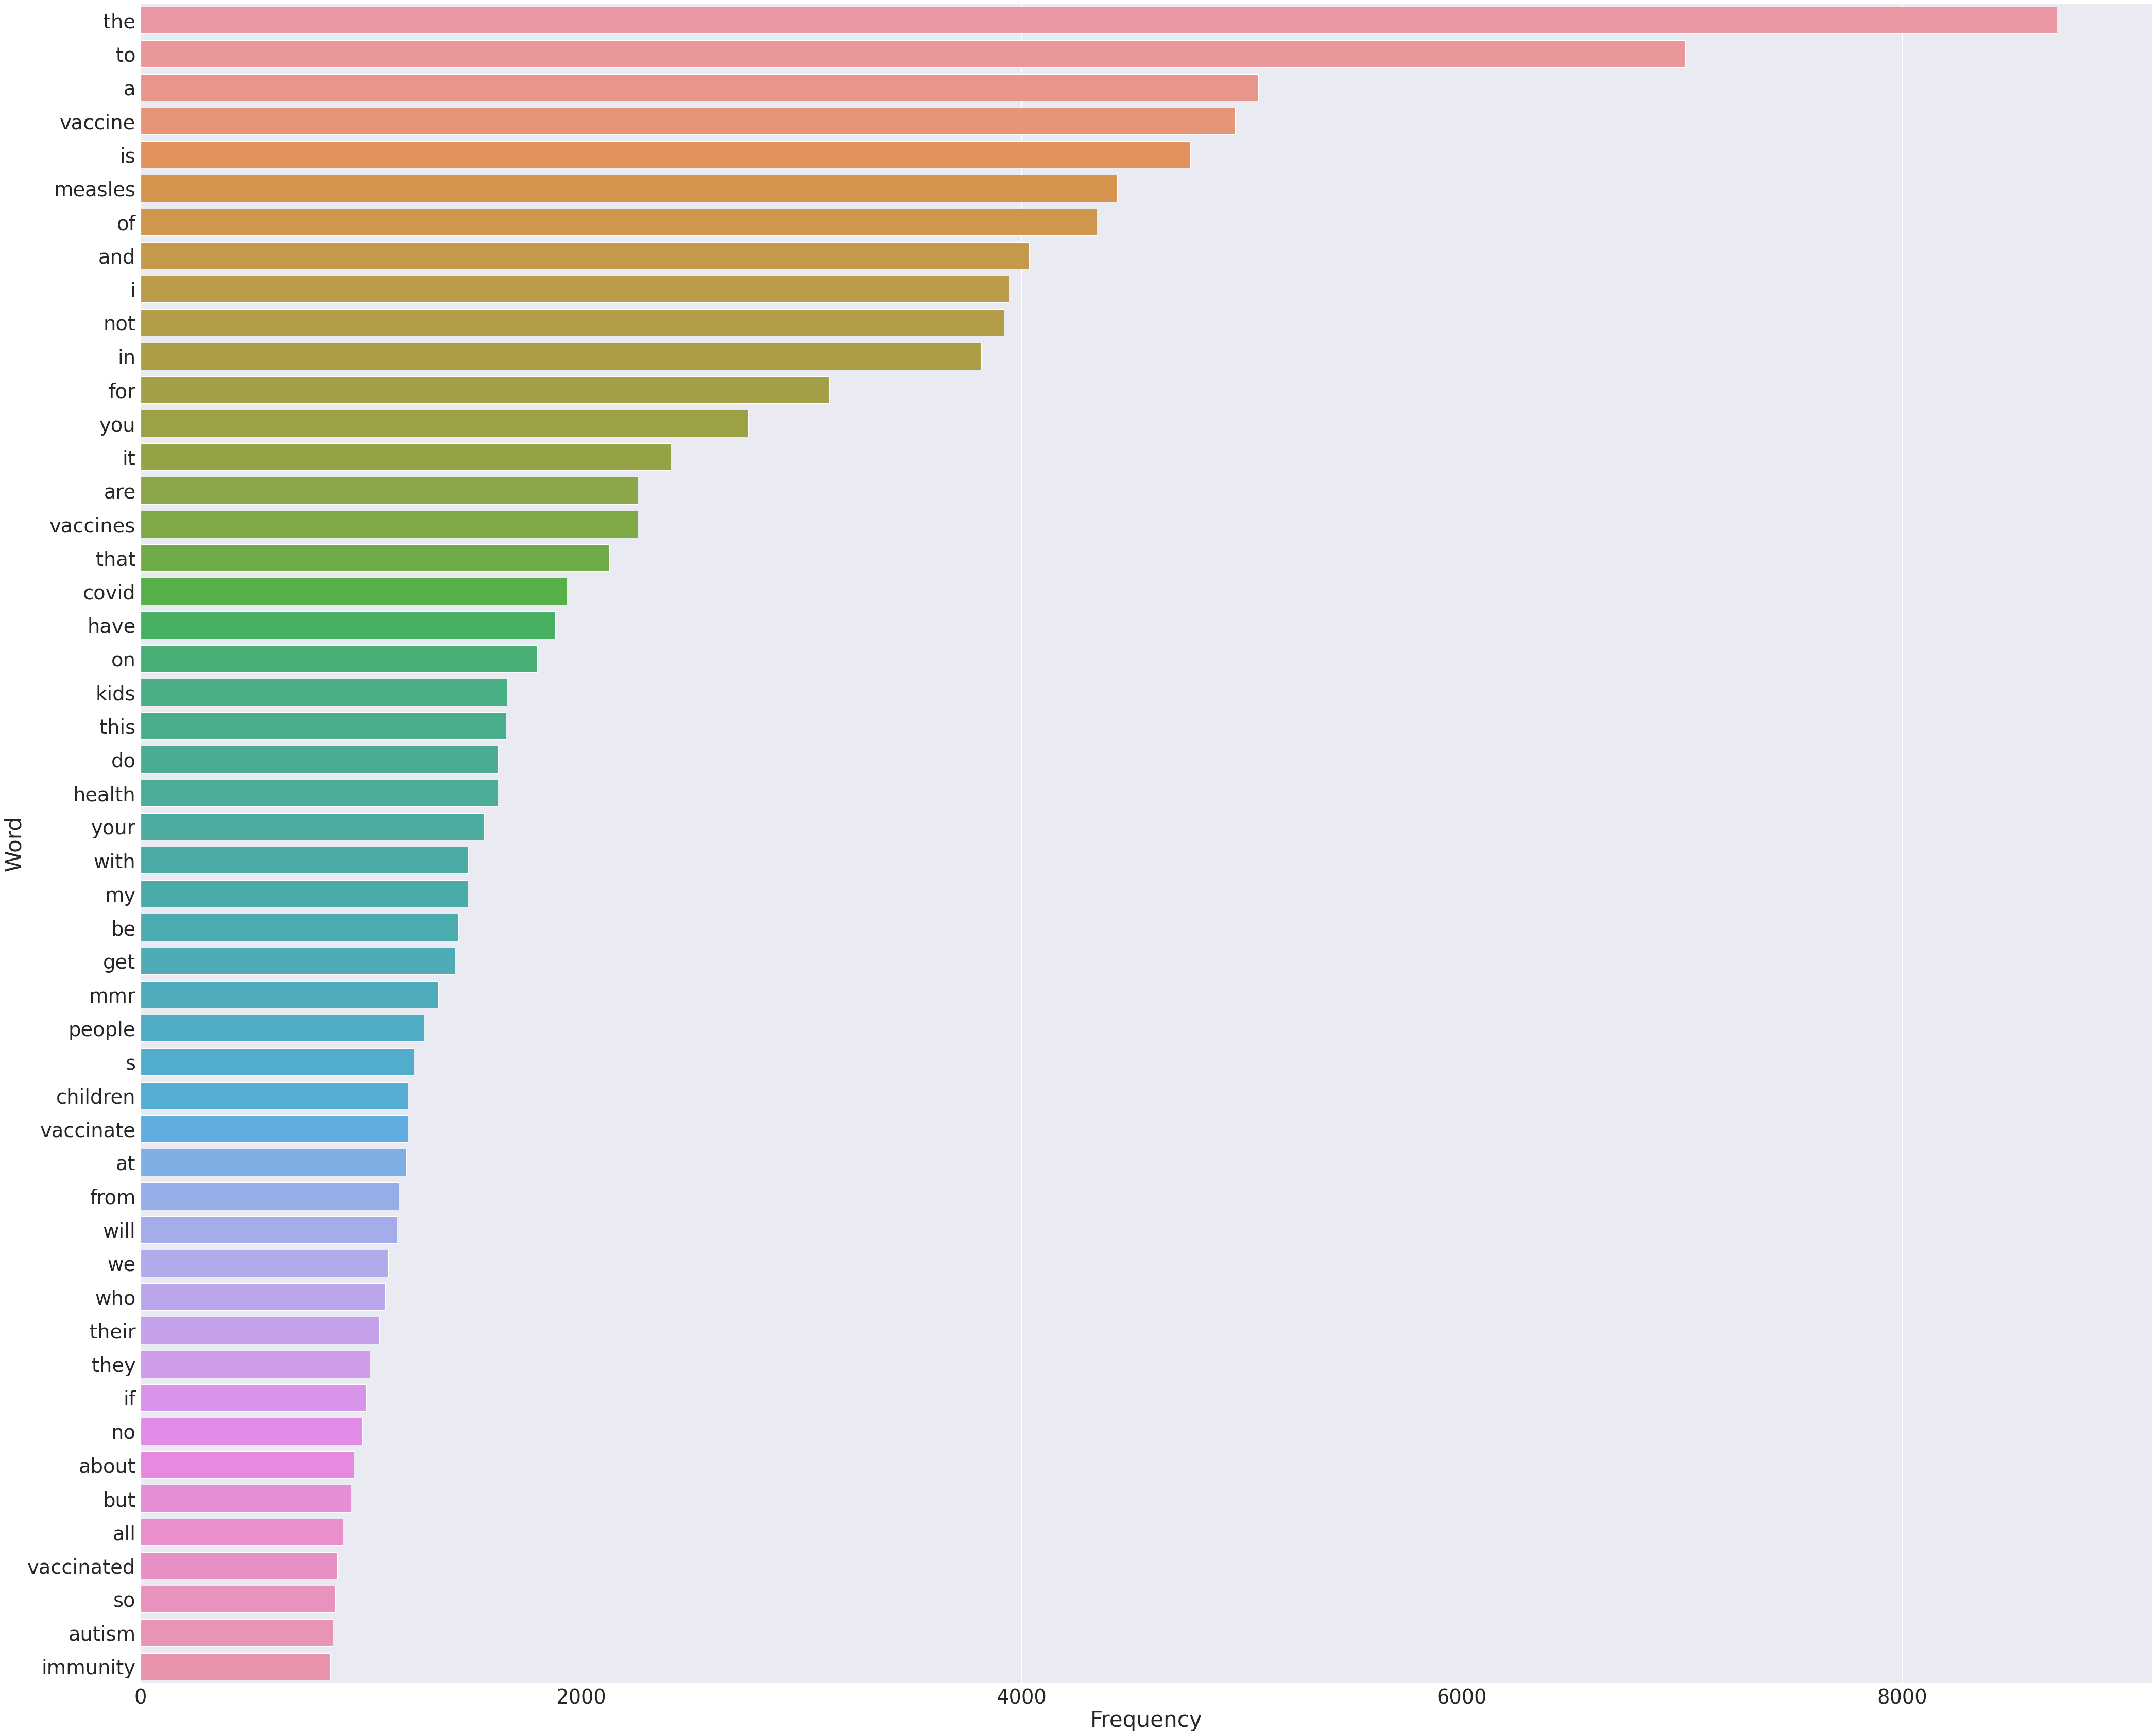

Training set size is 15976
Neutral tweets are 46.68252378567852%
Antivax tweets are 12.975713570355532%
Provax tweets are 40.34176264396595%


In [ ]:
# RUN THIS
# Visualization of the most common words (for better insights)
def tweetStatistics(tweets):
  all_words = []
  for tweet in tweets:
    for word in tweet.split():
      all_words.append(word)
  # Using pandas to merge the word column and the frequency column for seaborn barplot
  word_freq = pd.DataFrame(Counter(all_words).items(), columns = ['Word','Frequency']).sort_values(by = 'Frequency', ascending = False)
  figure = plt.figure()
  figure.set_figwidth(70)
  figure.set_figheight(60)
  sns.set(font_scale = 3.5)
  bar = sns.barplot(x = 'Frequency', y = 'Word', data = word_freq.head(50))
  plt.show()
  sns.set(font_scale = 1)

tweetStatistics(training_set['tweet'].tolist())
training_size = len(training_set['tweet'].tolist())
print('Training set size is %d' % training_size)
stats = training_set.groupby(['label']).count()
for stat, name in zip(stats['tweet'].tolist(), ['Neutral', 'Antivax', 'Provax']):
  print(name + ' tweets are ' + str(stat/training_size*100) + '%')


Useful functions for **perfomance enhancing** as well as **perfomance visualization**. These functions are using performance metrics (such as cross entropy and misclassification error based on accuracy, precision, recall etc...). The first one is used for the visualization of the degree in which the model is either underfitting or overfitting (**learning curves**) and the other two are used for performance sampling in order to create these **learning curves**. The last one is also used for **early stopping**

In [ ]:
# RUN THIS
def plotLearningCurves(x_axis, y_axis, x_label, y_label, curve_ids, x_best = None, y_best = None):
  if x_best is not None and y_best is not None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.annotate('Best score ' + str(x_best), xy = (x_best, y_best), arrowprops = dict(facecolor = 'black', shrink = 0.05))
  for y, id in zip(y_axis, curve_ids):
    plt.plot(x_axis, y, label = id)
  plt.title('Learning Curves')
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.legend(loc = 'lower right')
  plt.show()

@ignore_warnings(category = ConvergenceWarning)
def learningCurves(estimator, training_set, validation_set, scoring = log_loss, average = None, steps = None):
  valid_scores = []
  train_scores = []
  estimator.set_params(random_state = 0)

  # Every step is the 5% of the training size
  if steps is None:
    step_size = int(training_set[0].shape[0] * 0.05)
    steps = [size for size in range(step_size, training_set[0].shape[0], step_size)]

  for step in steps:
    x_train = training_set[0][0: step]
    y_train = training_set[1][0: step]
    clf = estimator.fit(x_train, y_train)

    if scoring.__name__ == 'log_loss':
      # Prediction for the whole validation set
      y_pred_valid = clf.predict_proba(validation_set[0])
      # Prediction for the same training portion
      y_pred_train = clf.predict_proba(x_train)
      valid_scores.append(scoring(validation_set[1], y_pred_valid))
      train_scores.append(scoring(y_train, y_pred_train))
    else: # Misclassification error will be computed
      # Prediction for the whole validation set
      y_pred_valid = clf.predict(validation_set[0])
      # Prediction for the same training portion
      y_pred_train = clf.predict(x_train)
      if 'average' in inspect.signature(scoring).parameters.keys() :
        valid_scores.append(1 - scoring(validation_set[1], y_pred_valid, average = average))
        train_scores.append(1 - scoring(y_train, y_pred_train, average = average))
      else:
        valid_scores.append(1 - scoring(validation_set[1], y_pred_valid))
        train_scores.append(1 - scoring(y_train, y_pred_train))

  plotLearningCurves(steps, [valid_scores, train_scores], 'Training Data Size', 'Error (' + scoring.__name__+ ')' , ['validation', 'training'])  

# Best iteration by early stopping
@ignore_warnings(category = ConvergenceWarning)
def findBestIteration(estimator, training_set, validation_set, scoring = log_loss, average = None, max_iters = 100, threshold = 35, stats = False):
  valid_scores = []
  train_scores = []
  best_score = 1
  best_iter = max_iters
  counter = 0
  i = 0
  
  for i in range(1, max_iters + 1): 
    # Epochs are increased by one each time
    estimator.set_params(max_iter = i) 
    estimator.set_params(random_state = 0)
    clf = estimator.fit(training_set[0], training_set[1])
  
    # Prediction for the whole validation and training set
    if scoring.__name__ == 'log_loss':
      y_pred_valid = clf.predict_proba(validation_set[0])
      valid_score = scoring(validation_set[1], y_pred_valid)
      if stats:
        y_pred_train = clf.predict_proba(training_set[0])
        train_score = scoring(training_set[1], y_pred_train)
    else: # Misclassification error will be computed
      y_pred_valid = clf.predict(validation_set[0])
      if 'average' in inspect.signature(scoring).parameters.keys():
        valid_score = 1 - scoring(validation_set[1], y_pred_valid, average = average)
        if stats:
          y_pred_train = clf.predict(training_set[0])
          train_score = 1 - scoring(training_set[1], y_pred_train, average = average)
      else:
        valid_score = 1 - scoring(validation_set[1], y_pred_valid)
        if stats:
          y_pred_train = clf.predict(training_set[0])
          train_score = 1 - scoring(training_set[1], y_pred_train)

    if valid_score < best_score:
      best_score = valid_score
      best_iter = i
      counter = 0
    else:
      counter += 1

    valid_scores.append(valid_score)
    if stats:
      train_scores.append(train_score)

    # Confident threshold is reached which means that probably the model will not do any better
    if counter == threshold:
        break

  if stats:
    plotLearningCurves(list(range(1, i + 1)), [valid_scores, train_scores], 'Number of Iterations', 'Error (' + scoring.__name__ + ')', ['validation', 'training'], best_iter, best_score)  
    
  return best_iter

Functions for **model training** and **model evaluation** (including all score measurements as well as the creation of confusion matrices for all classes together and for each class too). Model training can also use the above **early stopping** method to find the best iteration for the validation set in order to avoid overfitting. Also for better results there is a function for **optimal training** using Grid Search to find the best parameters for the model

In [ ]:
# RUN THIS
def plotConfusionMatrix(matrix, title, targets = None):
    ax = sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = "d")
    ax.set_title(title + '\n');
    if targets is None:
      ax.xaxis.set_ticklabels(['False', 'True'])
      ax.yaxis.set_ticklabels(['False', 'True'])
    else:
      ax.xaxis.set_ticklabels(targets)
      ax.yaxis.set_ticklabels(targets)
    plt.tick_params(axis = 'both', which = 'major', labelsize = 10, labelbottom = False, bottom = False, top = False, labeltop = True)
    plt.show()

# Training with early stopping option for better results in test set
@ignore_warnings(category = ConvergenceWarning)
def modelTraining(model, training_set, validation_set, early_stopping_metric = None, early_stopping_metric_avg = None, plot_curves = False):
  if early_stopping_metric is not None:
    best_iter = findBestIteration(model, training_set, validation_set, early_stopping_metric, early_stopping_metric_avg, stats = plot_curves)
    model.set_params(max_iter = best_iter)
  return model.fit(training_set[0], training_set[1])

def modelEvaluation(clf, test_set, targets, cm_plot = False):
  y_pred = clf.predict(test_set[0])
  # All metrics in one
  print(classification_report(test_set[1], y_pred, target_names = targets , digits = 5))
  if cm_plot:
    confusion_matrices = multilabel_confusion_matrix(test_set[1], y_pred, labels = [i for i in range(len(targets))])
    for matrix, target in zip(confusion_matrices, targets):
      plotConfusionMatrix(matrix, 'Confusion Matrix for ' + target)
      print()
    glob_confusion_matrix = confusion_matrix(test_set[1], y_pred, labels = [i for i in range(len(targets))])
    plotConfusionMatrix(glob_confusion_matrix, 'Global Confusion Matrix', targets)

# Optimized training using Grid Search
@ignore_warnings(category = ConvergenceWarning)
def modelTrainingOpt(model, training_set, validation_set, tuning_params, optimization_metric = log_loss, optimization_avg = None, early_stopping = False):
  if optimization_metric.__name__ == 'log_loss':
    grid_metric = make_scorer(log_loss, greater_is_better = False, needs_proba = True)
  elif optimization_metric.__name__ == 'accuracy_score':
    grid_metric = make_scorer(accuracy_score)
  else:
    grid_metric = make_scorer(optimization_metric, average = optimization_avg)
  
  model_grid = GridSearchCV(model, param_grid = tuning_params, scoring = grid_metric , cv = 3, verbose = 10)
  model_grid.fit(training_set[0], training_set[1])
  print(model_grid.best_params_)
  # Best estimator based on GridSearch
  best_model = model_grid.best_estimator_
  print(best_model.get_params())
  if early_stopping:
    return modelTraining(best_model, training_set, validation_set, optimization_metric, optimization_avg)
  return modelTraining(best_model, training_set, validation_set)


## **Model training using Bag of Words vectorizer**

Training using **Bag of Words vectorizer** along with  **standardization** in order to remove outliers and scaling the data for faster convergence. Both unigrams and bigrams are included and some feature elimination is applied to avoid overfitting and make the training process faster

In [ ]:
training_tweets = training_set['tweet'].tolist()
validation_tweets = validation_set['tweet'].tolist()

scaler = StandardScaler(with_mean = False)

# Vectorizer will also include bigrams because this helps the model to "understand" which words go together 
count_vect = CountVectorizer(ngram_range = (1, 2), max_df = 0.75, max_features = 7000)

# The vocabulary dictionary is created by the training tweets 
count_vect.fit(training_tweets)

# Bag of words represantation of training set for that vocabulary (scaling is applied because values are unscaled)
bow_training_tweets = scaler.fit_transform(count_vect.transform(training_tweets))
#bow_training_tweets = count_vect.transform(training_tweets)

# Bag of words represantation of validation set for that vocabulary (scaling is applied because values are unscaled)
bow_validation_tweets = scaler.transform(count_vect.transform(validation_tweets))
#bow_validation_tweets = count_vect.transform(validation_tweets)

# New training and validation sets according to their vectorized versions
bow_training_set = [bow_training_tweets, training_set['label'].to_numpy()]
bow_validation_set = [bow_validation_tweets, validation_set['label'].to_numpy()]


                       Validation Set


              precision    recall  f1-score   support

     neutral    0.75646   0.76995   0.76315      1065
     antivax    0.54340   0.48649   0.51337       296
      provax    0.68382   0.69273   0.68824       921

    accuracy                        0.70202      2282
   macro avg    0.66122   0.64972   0.65492      2282
weighted avg    0.69950   0.70202   0.70052      2282



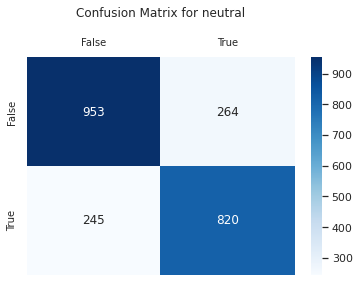

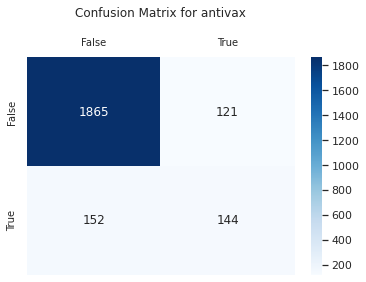

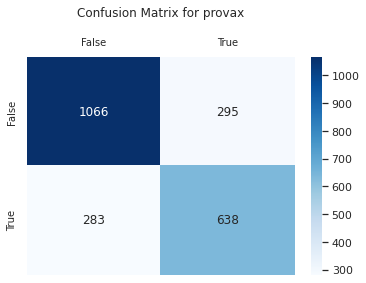

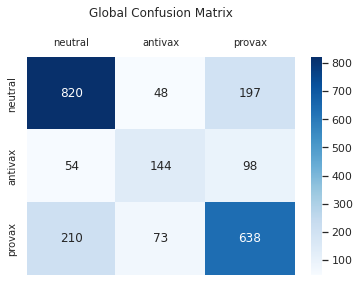

                       Training Set


              precision    recall  f1-score   support

     neutral    0.95575   0.94985   0.95279      7458
     antivax    0.96694   0.90304   0.93390      2073
      provax    0.93060   0.95702   0.94362      6445

    accuracy                        0.94667     15976
   macro avg    0.95110   0.93664   0.94344     15976
weighted avg    0.94705   0.94667   0.94664     15976



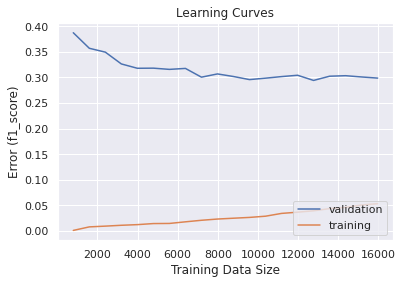

In [ ]:
tuning_params = [
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l1'], 'solver': ['saga']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['lbfgs']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.15, 0.3, 0.5, 0.75]},
]

#softmax = modelTrainingOpt(LogisticRegression(multi_class = 'multinomial'), bow_training_set, bow_validation_set, tuning_params, log_loss)
softmax = modelTraining(LogisticRegression(multi_class = 'multinomial', C = 0.1, penalty = 'l1', solver = 'saga'), bow_training_set, bow_validation_set)
print('                       Validation Set\n\n')
modelEvaluation(softmax, bow_validation_set, ['neutral', 'antivax', 'provax'], cm_plot = True)
print('                       Training Set\n\n')
modelEvaluation(softmax, bow_training_set, ['neutral', 'antivax','provax'])
learningCurves(softmax, bow_training_set, bow_validation_set, f1_score, average = 'weighted')



## **Model training using Hashing vectorizer**

Training using **Hashing vectorizer** in a manner similar to the above training operation because both vectorizers are somehow working the same. In this case only unigrams are included to avoid the large volume of features that could easily cause hash colisions

In [ ]:
training_tweets = training_set['tweet'].tolist()
validation_tweets = validation_set['tweet'].tolist()

scaler = StandardScaler(with_mean = False)

# Vectorizer will exclusively include unigrams because conflicts might be occured
hash_vect = HashingVectorizer(ngram_range = (1, 1), n_features = 20000)

# The vocabulary dictionary is created by the training tweets 
hash_vect.fit(training_tweets)

# Represantation of training set using hashing trick for that vocabulary (scaling is applied because values are unscaled)
hash_training_tweets = scaler.fit_transform(hash_vect.transform(training_tweets))
#hash_training_tweets = hash_vect.transform(training_tweets)

# Represantation of validation set using hashing trick for that vocabulary (scaling is applied because values are unscaled)
hash_validation_tweets = scaler.transform(hash_vect.transform(validation_tweets))
#hash_validation_tweets = hash_vect.transform(validation_tweets)

# New training and validation sets according to their vectorized versions
hash_training_set = [hash_training_tweets, training_set['label'].to_numpy()]
hash_validation_set = [hash_validation_tweets, validation_set['label'].to_numpy()]

                       Validation Set


              precision    recall  f1-score   support

     neutral    0.73861   0.70047   0.71904      1065
     antivax    0.50211   0.40203   0.44653       296
      provax    0.63865   0.71770   0.67587       921

    accuracy                        0.66871      2282
   macro avg    0.62646   0.60673   0.61381      2282
weighted avg    0.66759   0.66871   0.66627      2282



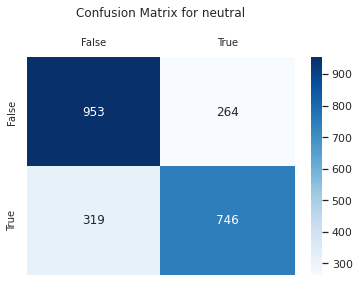

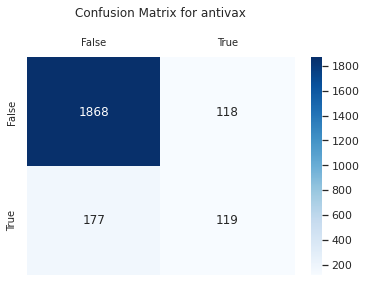

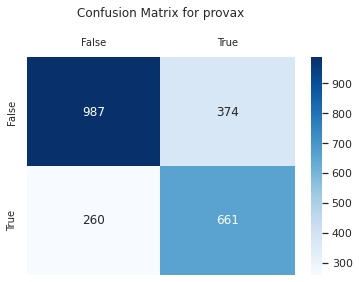

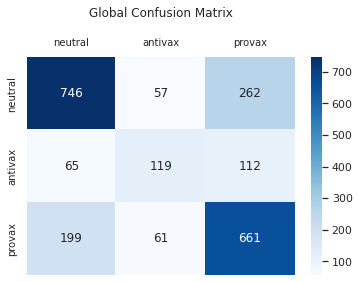

                       Training Set


              precision    recall  f1-score   support

     neutral    0.95881   0.95830   0.95856      7458
     antivax    0.97534   0.87747   0.92382      2073
      provax    0.93075   0.96137   0.94581      6445

    accuracy                        0.94905     15976
   macro avg    0.95497   0.93238   0.94273     15976
weighted avg    0.94964   0.94905   0.94891     15976



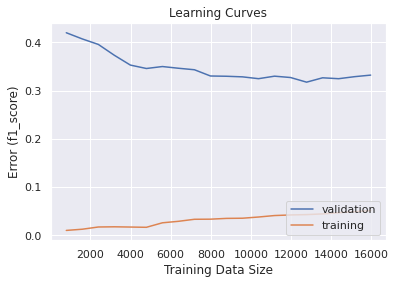

In [ ]:
tuning_params = [
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l1'], 'solver': ['saga']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['lbfgs']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.15, 0.3, 0.5, 0.75]},
]

#softmax = modelTrainingOpt(LogisticRegression(multi_class = 'multinomial'), hash_training_set, hash_validation_set, tuning_params, log_loss)
softmax = modelTraining(LogisticRegression(multi_class = 'multinomial', C = 0.1, penalty = 'l1', solver = 'saga'), hash_training_set, hash_validation_set)
print('                       Validation Set\n\n')
modelEvaluation(softmax, hash_validation_set, ['neutral', 'antivax', 'provax'], cm_plot = True)
print('                       Training Set\n\n')
modelEvaluation(softmax, hash_training_set, ['neutral', 'antivax','provax'])
learningCurves(softmax, hash_training_set, hash_validation_set, f1_score, average = 'weighted')

## **Model training using TF-IDF vectorizer**

Training using **TF-IDF vectorizer** without scaling because the vector values are already scaled by the **TF-IDF** transformation. Like Bag of Words, both unigrams and bigrams are included and some feature elimination is applied to avoid overfitting and make the training process faster



In [ ]:
training_tweets = training_set['tweet'].tolist()
validation_tweets = validation_set['tweet'].tolist()

# Vectorizer will also include bigrams because this helps the model to "understand" which words go together 
tfidf_vect = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.75, max_features = 12000)

# The vocabulary dictionary is created by the training tweets 
tfidf_vect.fit(training_tweets)

# TF-IDF represantation of training set for that vocabulary (TF-IDF does not need any scaling as it does some scaling itself)
tfidf_training_tweets = tfidf_vect.transform(training_tweets)

# TF-IDF represantation of validation set for that vocabulary
tfidf_validation_tweets = tfidf_vect.transform(validation_tweets)

# New training and validation sets according to their vectorized versions
tfidf_training_set = [tfidf_training_tweets, training_set['label'].to_numpy()]
tfidf_validation_set = [tfidf_validation_tweets, validation_set['label'].to_numpy()]


                       Validation Set


              precision    recall  f1-score   support

     neutral    0.78102   0.80376   0.79223      1065
     antivax    0.71978   0.44257   0.54812       296
      provax    0.69821   0.76113   0.72831       921

    accuracy                        0.73970      2282
   macro avg    0.73300   0.66915   0.68955      2282
weighted avg    0.73965   0.73970   0.73477      2282



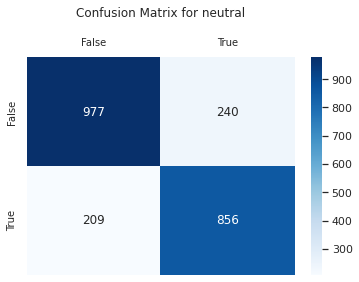

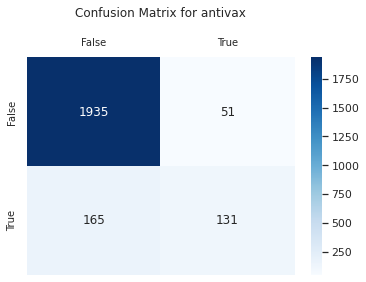

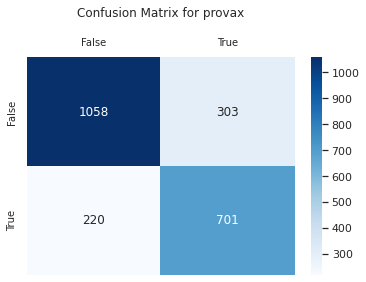

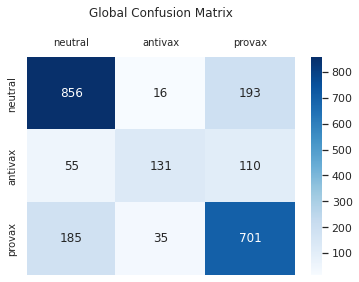

                       Training Set


              precision    recall  f1-score   support

     neutral    0.87723   0.89582   0.88643      7458
     antivax    0.89805   0.55668   0.68731      2073
      provax    0.81442   0.89403   0.85237      6445

    accuracy                        0.85109     15976
   macro avg    0.86323   0.78217   0.80870     15976
weighted avg    0.85459   0.85109   0.84685     15976



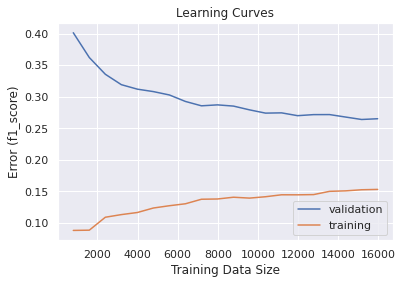

In [ ]:
tuning_params = [
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l1'], 'solver': ['saga']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['lbfgs']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.15, 0.3, 0.5, 0.75]},
]

#softmax = modelTrainingOpt(LogisticRegression(multi_class = 'multinomial'), tfidf_training_set, tfidf_validation_set, tuning_params, log_loss)
softmax = modelTraining(LogisticRegression(multi_class = 'multinomial', C = 1, penalty = 'l2', solver = 'lbfgs'), tfidf_training_set, tfidf_validation_set)
print('                       Validation Set\n\n')
modelEvaluation(softmax, tfidf_validation_set, ['neutral', 'antivax', 'provax'], cm_plot = True)
print('                       Training Set\n\n')
modelEvaluation(softmax, tfidf_training_set, ['neutral', 'antivax','provax'])
learningCurves(softmax, tfidf_training_set, tfidf_validation_set, f1_score, average = 'weighted')



## **Further techniques in order to achieve better perfomance**

Having a glance at the results of the previous statistical analysis anyone can see that the dataset has a lot of short or commonly used words (**stopwords**). A good practice for that is to remove these short words and **stopwords** but some of these words may express a sentiment so it is not a very good idea to remove them (e.g 1st and 2nd pronouns). Also some words are having the same lemmas but they are treated as totally different so it is helpful to do some **lemmatization** (word transformation to their lemmas). In order to make the process of lemmatization more efficient and precise, it can be perfectly combined with the **POS tagging** technique which annotates the words with their part of speech in the sentence

0    sip shop come thru right marjais popularnobodi...
1    i not know you family i not take covid vaccine...
2    msignorile immunization mandatory period oklah...
3    president obama speak favor vaccination child ...
4    myfoxla arizona monitor hundred measles link d...
5    i get whooping cough vaccine day i bring baby ...
6    prosecutor ken ervin i want know recklessly ki...
7    uberfacts average people complain live long re...
8    legacy jennymccarthy take clothes contribute g...
9    uberfacts average people complain live long re...
Name: tweet, dtype: object
0    user massive surge covid death immediately vac...
1    require vaccine school parent guardian child s...
2    kcstar two johnson county child measles sethmn...
3                    good state best bad vaccinate kid
4    nothing like kill fear alyssamilano vaccine fe...
5    i not subscribe panic jour measles remember ebola
6    punx fav song check aptbs explode head ego dea...
7             happend covid vaccine te

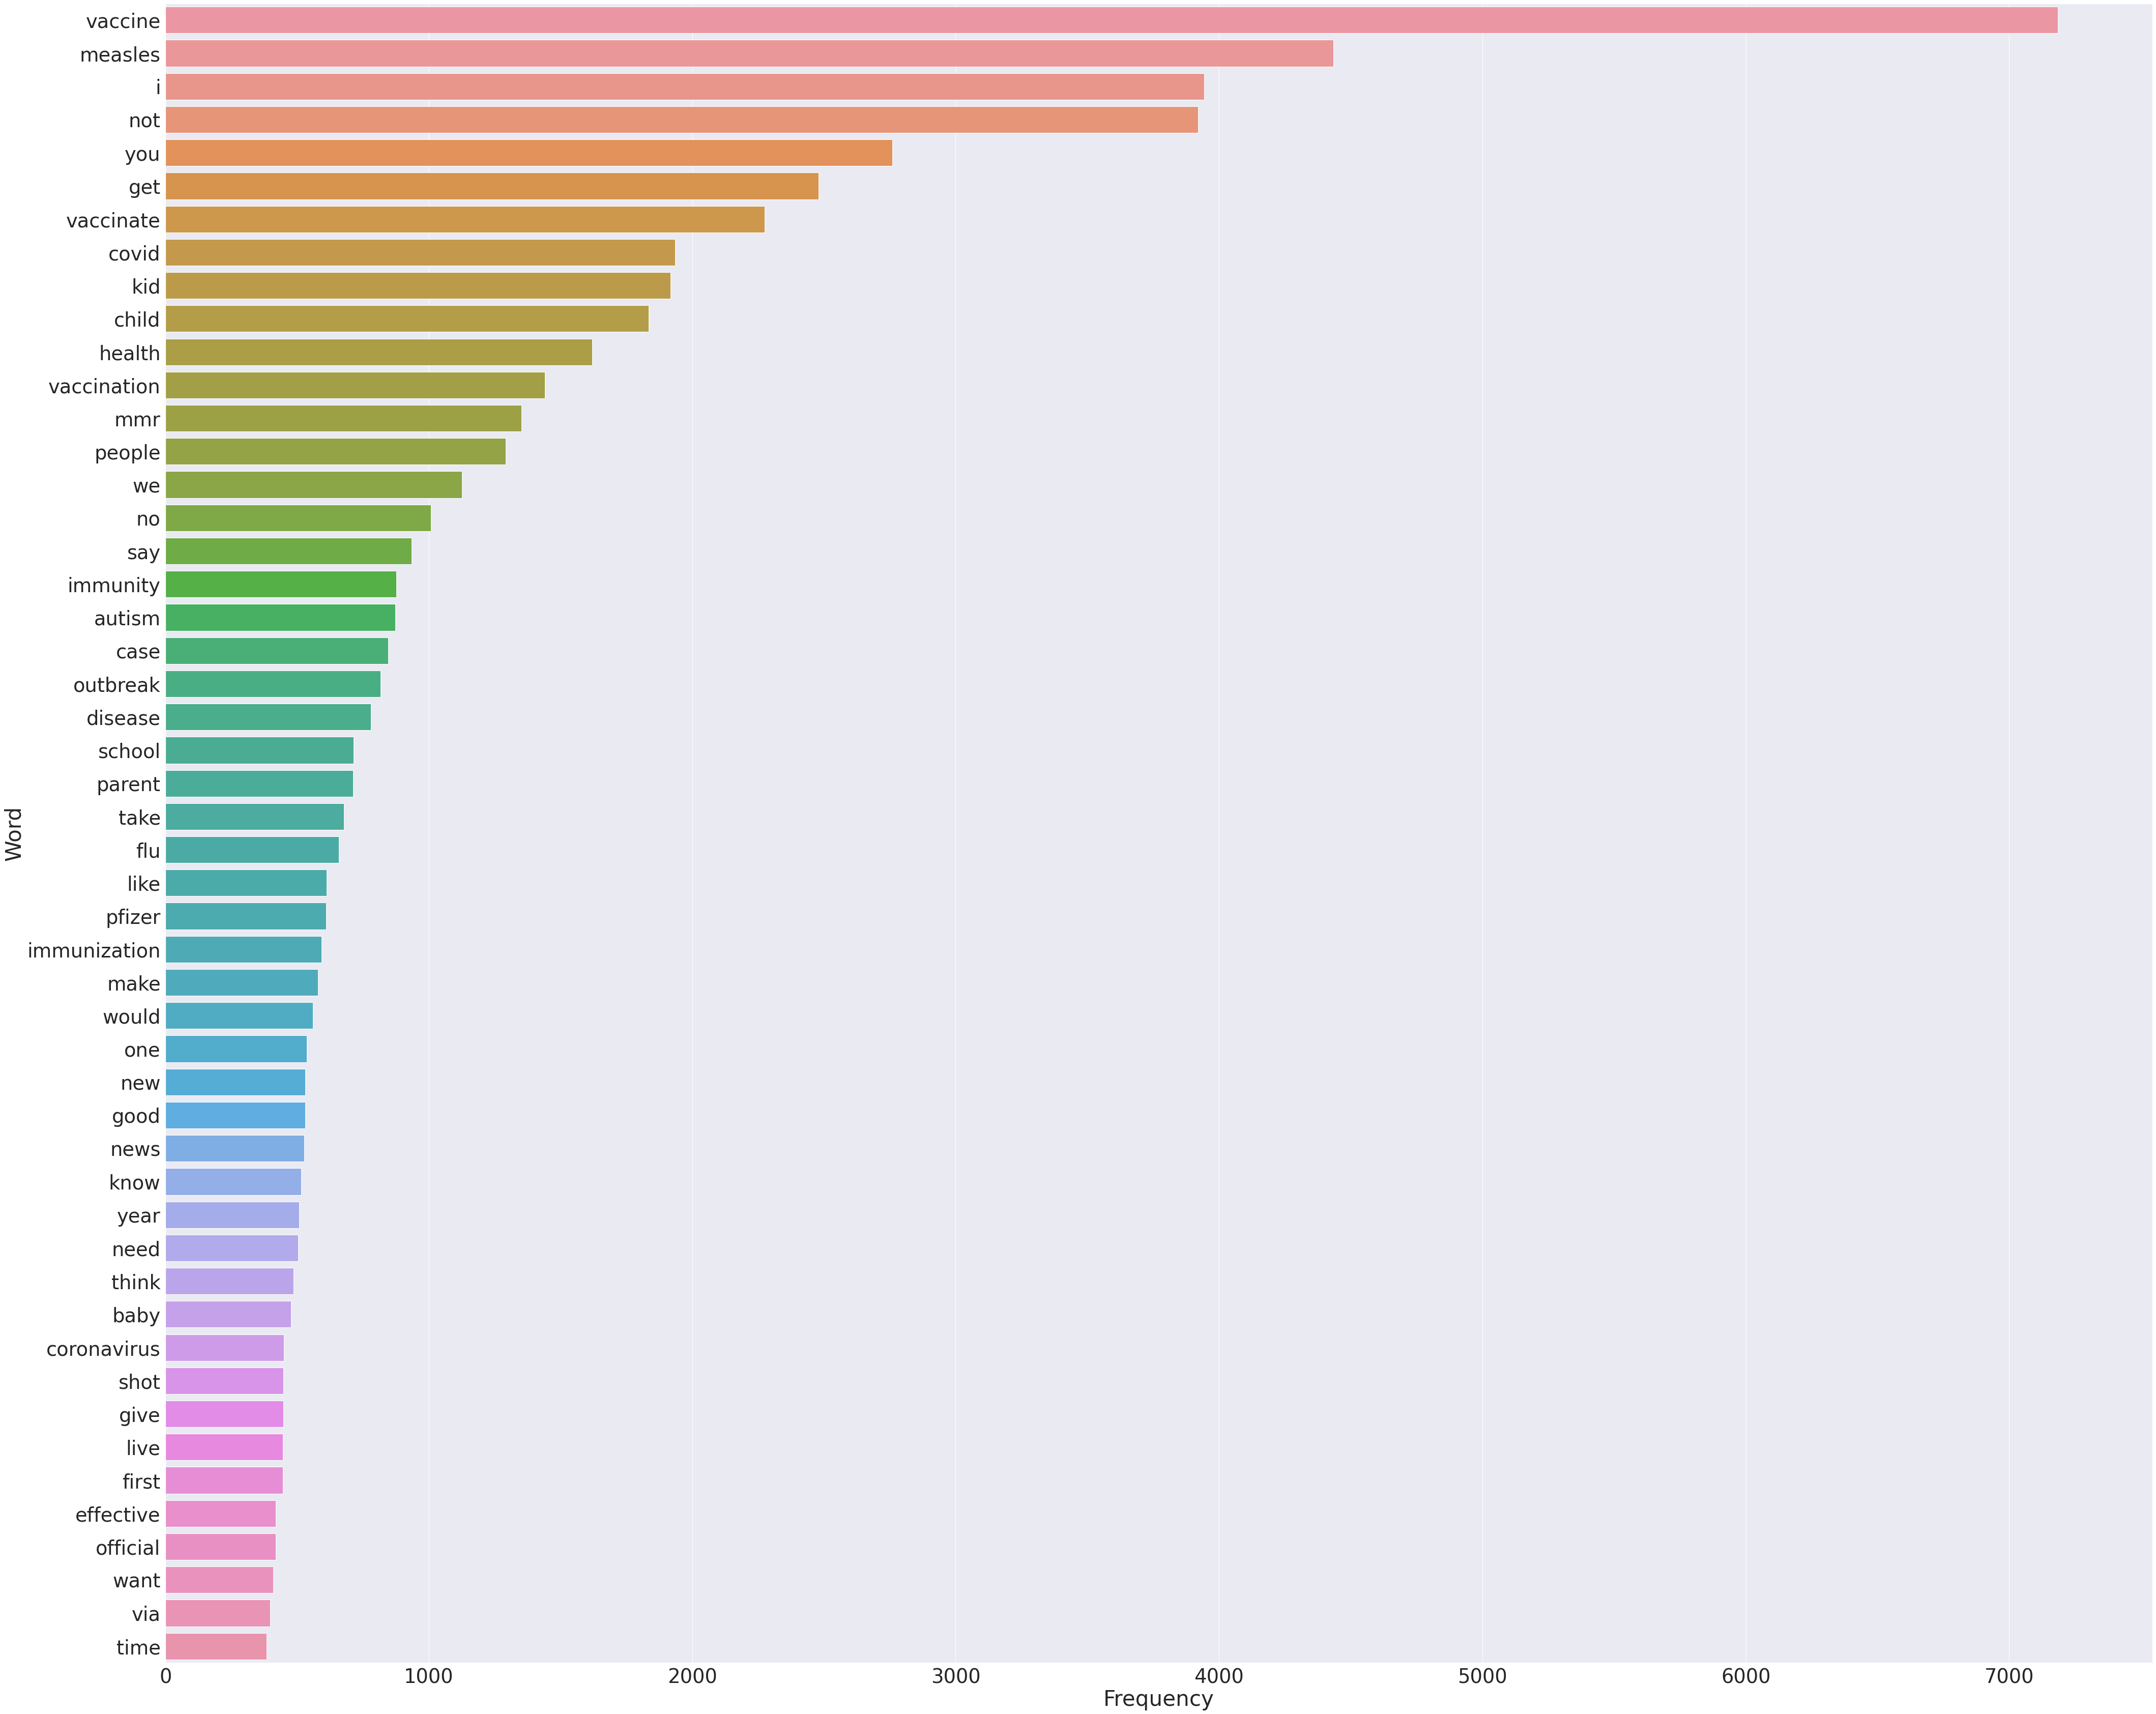

In [ ]:
# RUN THIS
def get_pos(tag):
  if tag.startswith('J'):
    return wordnet.ADJ
  elif tag.startswith('V'):
    return wordnet.VERB
  elif tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN

def normalization(tweet, lemmatizer):
  tagged_tweet = pos_tag(tweet.split())
  clean_tweet = ' '.join([lemmatizer.lemmatize(word, get_pos(tag)) for word, tag in tagged_tweet])
  return clean_tweet

def extra_preprocessing(df, column):
  lemmatizer = WordNetLemmatizer()
  #stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  # Some words that might be useful for sentiment recognition
  special_word_set = set(['no', 'we', 'i', 'you', 'not'])
  # Lemmatization
  df[column] = df[column].apply(lambda tweet: normalization(tweet, lemmatizer))
  # Stopword removal and length filtering
  df[column] = df[column].apply(lambda tweet: ' '.join([w for w in tweet.split() if (len(w) > 2 and w not in stop_words) or w in special_word_set]))

extra_preprocessing(training_set, 'tweet')
extra_preprocessing(validation_set, 'tweet')

print(training_set['tweet'].head(10))
print(validation_set['tweet'].head(10))

tweetStatistics(training_set['tweet'].tolist())



**TF-IDF** proved to be the best vectorizer. So in order to improve the performance using **TF-IDF**,  the model will be trained again with the above extra preprocessed dataset and also with some extra optimization techniques like **early stopping**

In [ ]:
# RUN THIS
training_tweets = training_set['tweet'].tolist()
validation_tweets = validation_set['tweet'].tolist()

# Vectorizer will also include bigrams because this helps the model to "understand" which words go together 
tfidf_vect = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.75, max_features = 12000)

# The vocabulary dictionary is created by the training tweets 
tfidf_vect.fit(training_tweets)

# TF-IDF represantation of training set for that vocabulary
tfidf_training_tweets = tfidf_vect.transform(training_tweets)

# TF-IDF represantation of validation set for that vocabulary
tfidf_validation_tweets = tfidf_vect.transform(validation_tweets)

# New training and validation sets according to their vectorized versions
tfidf_training_set = [tfidf_training_tweets, training_set['label'].to_numpy()]
tfidf_validation_set = [tfidf_validation_tweets, validation_set['label'].to_numpy()]

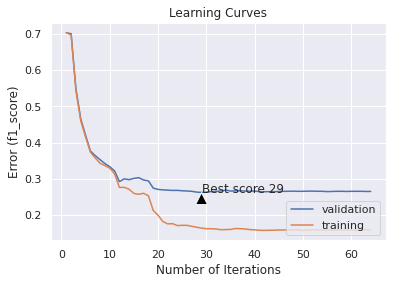

                       Validation Set


              precision    recall  f1-score   support

     neutral    0.78552   0.79437   0.78992      1065
     antivax    0.70352   0.47297   0.56566       296
      provax    0.70179   0.76656   0.73275       921

    accuracy                        0.74145      2282
   macro avg    0.73027   0.67797   0.69611      2282
weighted avg    0.74109   0.74145   0.73775      2282



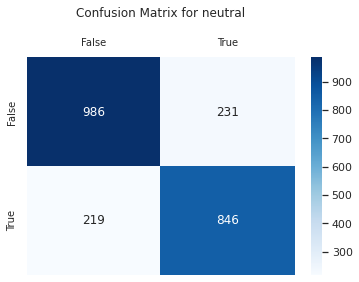

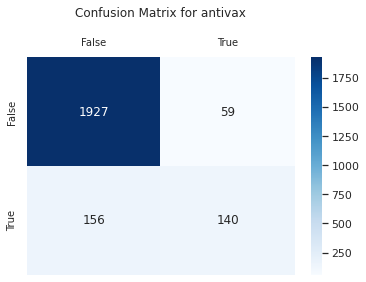

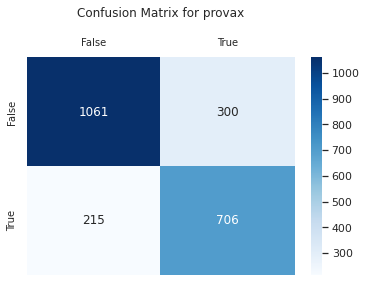

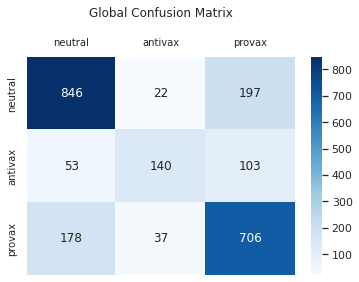

                       Training Set


              precision    recall  f1-score   support

     neutral    0.86791   0.88281   0.87530      7458
     antivax    0.85587   0.55572   0.67388      2073
      provax    0.80721   0.88223   0.84306      6445

    accuracy                        0.84014     15976
   macro avg    0.84367   0.77359   0.79741     15976
weighted avg    0.84186   0.84014   0.83616     15976



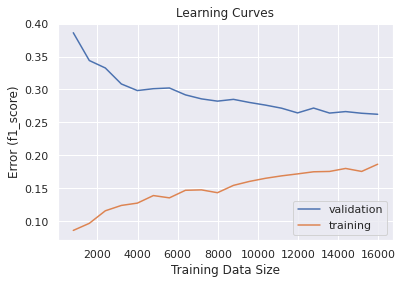

In [ ]:
tuning_params = [
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l1'], 'solver': ['saga']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['lbfgs']},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.15, 0.3, 0.5, 0.75]},
]

#softmax = modelTrainingOpt(LogisticRegression(multi_class = 'multinomial'), tfidf_training_set, tfidf_validation_set, tuning_params, log_loss, early_stopping = True)
softmax = modelTraining(LogisticRegression(multi_class = 'multinomial'), tfidf_training_set, tfidf_validation_set, f1_score, 'weighted' , True)
print('                       Validation Set\n\n')
modelEvaluation(softmax, tfidf_validation_set, ['neutral', 'antivax', 'provax'], cm_plot = True)
print('                       Training Set\n\n')
modelEvaluation(softmax, tfidf_training_set, ['neutral', 'antivax','provax'])
learningCurves(softmax, tfidf_training_set, tfidf_validation_set, f1_score, average = 'weighted')

In [ ]:
# RUN THIS TO EVALUATE TEST SET
softmax = modelTraining(LogisticRegression(multi_class = 'multinomial', C = 1, penalty = 'l2', solver = 'lbfgs', max_iter = 29), tfidf_training_set, tfidf_validation_set)
modelEvaluation(softmax, tfidf_validation_set, ['neutral', 'antivax', 'provax'])

              precision    recall  f1-score   support

     neutral    0.78552   0.79437   0.78992      1065
     antivax    0.70352   0.47297   0.56566       296
      provax    0.70179   0.76656   0.73275       921

    accuracy                        0.74145      2282
   macro avg    0.73027   0.67797   0.69611      2282
weighted avg    0.74109   0.74145   0.73775      2282



C = 0.1, penalty = l1,  l1_ratio = None, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.80479   0.66197   0.72643      1065
     antivax    0.59048   0.20946   0.30923       296
      provax    0.57494   0.81216   0.67327       921

    accuracy                        0.66389      2282
   macro avg    0.65674   0.56120   0.56964      2282
weighted avg    0.68423   0.66389   0.65086      2282



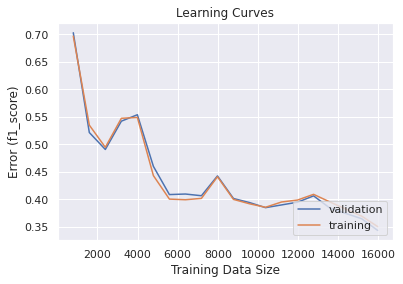

C = 0.25, penalty = l1,  l1_ratio = None, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.80541   0.72676   0.76407      1065
     antivax    0.60494   0.33108   0.42795       296
      provax    0.62640   0.78827   0.69808       921

    accuracy                        0.70026      2282
   macro avg    0.67892   0.61537   0.63003      2282
weighted avg    0.70716   0.70026   0.69384      2282



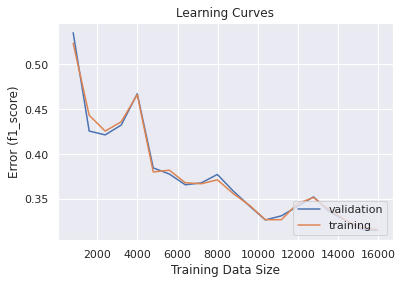

C = 0.5, penalty = l1,  l1_ratio = None, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78498   0.78498   0.78498      1065
     antivax    0.77344   0.33446   0.46698       296
      provax    0.66208   0.78284   0.71741       921

    accuracy                        0.72568      2282
   macro avg    0.74016   0.63409   0.65646      2282
weighted avg    0.73388   0.72568   0.71646      2282



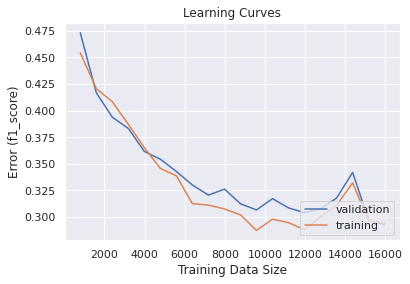

C = 0.75, penalty = l1,  l1_ratio = None, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.79578   0.77934   0.78748      1065
     antivax    0.75641   0.39865   0.52212       296
      provax    0.67498   0.79370   0.72954       921

    accuracy                        0.73576      2282
   macro avg    0.74239   0.65723   0.67971      2282
weighted avg    0.74192   0.73576   0.72967      2282



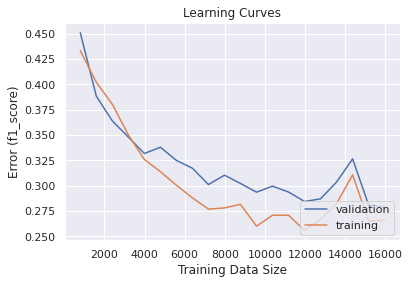

C = 1, penalty = l1,  l1_ratio = None, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.80136   0.77277   0.78681      1065
     antivax    0.71512   0.41554   0.52564       296
      provax    0.68144   0.80130   0.73653       921

    accuracy                        0.73795      2282
   macro avg    0.73264   0.66320   0.68299      2282
weighted avg    0.74178   0.73795   0.73264      2282



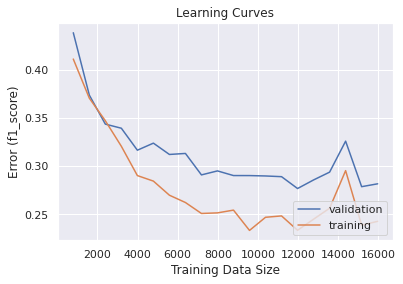

C = 0.1, penalty = l2,  l1_ratio = None, solver = lbfgs, 
              precision    recall  f1-score   support

     neutral    0.75668   0.79718   0.77641      1065
     antivax    0.72973   0.18243   0.29189       296
      provax    0.64641   0.76221   0.69955       921

    accuracy                        0.70333      2282
   macro avg    0.71094   0.58061   0.58928      2282
weighted avg    0.70868   0.70333   0.68254      2282



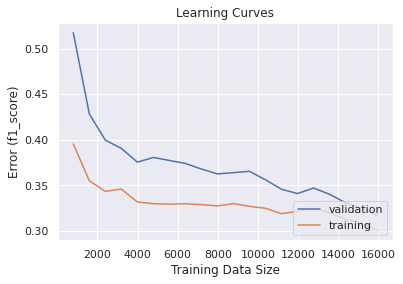

C = 0.25, penalty = l2,  l1_ratio = None, solver = lbfgs, 
              precision    recall  f1-score   support

     neutral    0.76869   0.82066   0.79382      1065
     antivax    0.78899   0.29054   0.42469       296
      provax    0.68147   0.76656   0.72151       921

    accuracy                        0.73006      2282
   macro avg    0.74638   0.62592   0.64668      2282
weighted avg    0.73612   0.73006   0.71676      2282



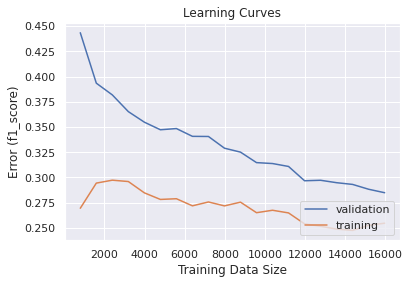

C = 0.5, penalty = l2,  l1_ratio = None, solver = lbfgs, 
              precision    recall  f1-score   support

     neutral    0.79041   0.78967   0.79004      1065
     antivax    0.73006   0.40203   0.51852       296
      provax    0.68436   0.78393   0.73077       921

    accuracy                        0.73707      2282
   macro avg    0.73495   0.65854   0.67978      2282
weighted avg    0.73978   0.73707   0.73090      2282



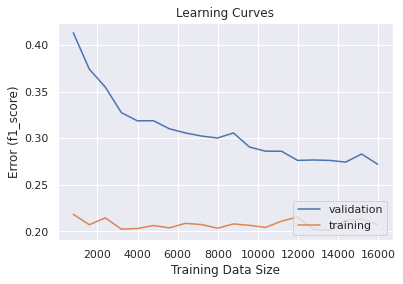

C = 0.75, penalty = l2,  l1_ratio = None, solver = lbfgs, 
              precision    recall  f1-score   support

     neutral    0.78558   0.79812   0.79180      1065
     antivax    0.72941   0.41892   0.53219       296
      provax    0.69417   0.77633   0.73296       921

    accuracy                        0.74014      2282
   macro avg    0.73639   0.66446   0.68565      2282
weighted avg    0.74140   0.74014   0.73438      2282



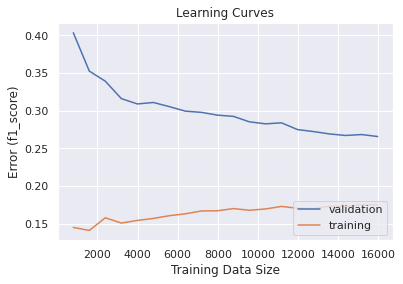

C = 1, penalty = l2,  l1_ratio = None, solver = lbfgs, 
              precision    recall  f1-score   support

     neutral    0.78552   0.79437   0.78992      1065
     antivax    0.70352   0.47297   0.56566       296
      provax    0.70179   0.76656   0.73275       921

    accuracy                        0.74145      2282
   macro avg    0.73027   0.67797   0.69611      2282
weighted avg    0.74109   0.74145   0.73775      2282



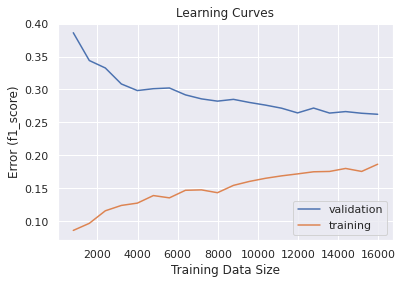

C = 0.1, penalty = elasticnet,  l1_ratio = 0.15, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78487   0.75023   0.76716      1065
     antivax    0.72826   0.22635   0.34536       296
      provax    0.62201   0.79153   0.69661       921

    accuracy                        0.69895      2282
   macro avg    0.71172   0.58937   0.60304      2282
weighted avg    0.71180   0.69895   0.68397      2282



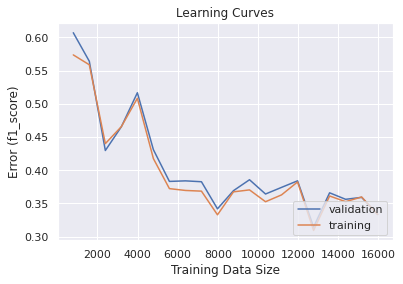

C = 0.1, penalty = elasticnet,  l1_ratio = 0.3, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.76813   0.75587   0.76195      1065
     antivax    0.69048   0.19595   0.30526       296
      provax    0.61304   0.76547   0.68083       921

    accuracy                        0.68712      2282
   macro avg    0.69055   0.57243   0.58268      2282
weighted avg    0.69547   0.68712   0.66997      2282



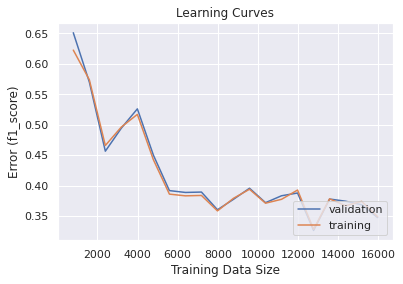

C = 0.1, penalty = elasticnet,  l1_ratio = 0.5, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.76369   0.74648   0.75499      1065
     antivax    0.68750   0.18581   0.29255       296
      provax    0.60207   0.75896   0.67147       921

    accuracy                        0.67879      2282
   macro avg    0.68442   0.56375   0.57300      2282
weighted avg    0.68858   0.67879   0.66130      2282



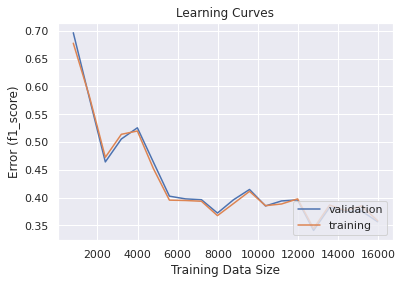

C = 0.1, penalty = elasticnet,  l1_ratio = 0.75, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.76260   0.73897   0.75060      1065
     antivax    0.62136   0.21622   0.32080       296
      provax    0.59808   0.74484   0.66344       921

    accuracy                        0.67353      2282
   macro avg    0.66068   0.56668   0.57828      2282
weighted avg    0.67788   0.67353   0.65967      2282



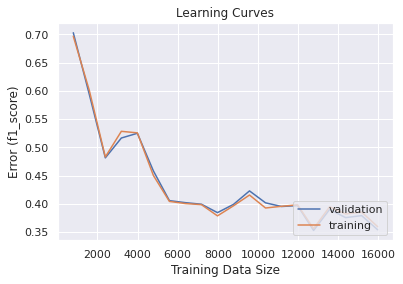

C = 0.25, penalty = elasticnet,  l1_ratio = 0.15, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78422   0.77465   0.77940      1065
     antivax    0.66857   0.39527   0.49682       296
      provax    0.66635   0.76330   0.71154       921

    accuracy                        0.72086      2282
   macro avg    0.70638   0.64441   0.66259      2282
weighted avg    0.72165   0.72086   0.71536      2282



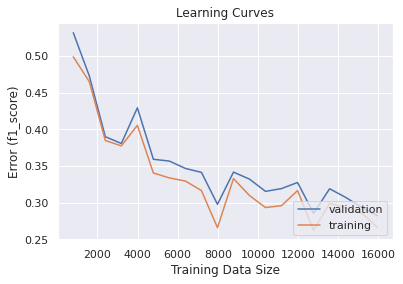

C = 0.25, penalty = elasticnet,  l1_ratio = 0.3, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78430   0.77840   0.78134      1065
     antivax    0.66265   0.37162   0.47619       296
      provax    0.65911   0.75787   0.70505       921

    accuracy                        0.71735      2282
   macro avg    0.70202   0.63597   0.65419      2282
weighted avg    0.71799   0.71735   0.71097      2282



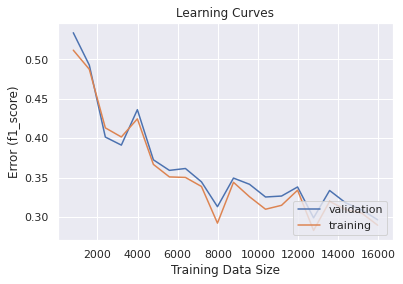

C = 0.25, penalty = elasticnet,  l1_ratio = 0.5, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.77820   0.77746   0.77783      1065
     antivax    0.65409   0.35135   0.45714       296
      provax    0.65439   0.75244   0.70000       921

    accuracy                        0.71209      2282
   macro avg    0.69556   0.62709   0.64499      2282
weighted avg    0.71213   0.71209   0.70482      2282



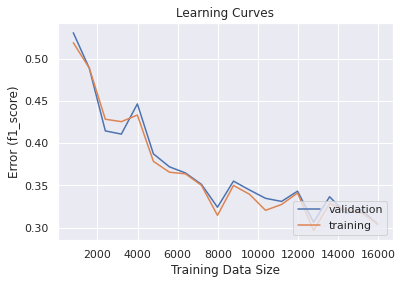

C = 0.25, penalty = elasticnet,  l1_ratio = 0.75, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.77183   0.77183   0.77183      1065
     antivax    0.63314   0.36149   0.46022       296
      provax    0.65076   0.74050   0.69274       921

    accuracy                        0.70596      2282
   macro avg    0.68524   0.62461   0.64159      2282
weighted avg    0.70498   0.70596   0.69949      2282



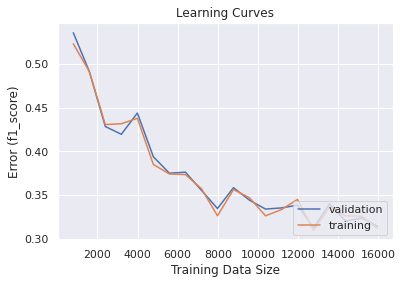

C = 0.5, penalty = elasticnet,  l1_ratio = 0.15, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78499   0.79531   0.79011      1065
     antivax    0.65333   0.49662   0.56430       296
      provax    0.69836   0.74159   0.71933       921

    accuracy                        0.73488      2282
   macro avg    0.71223   0.67784   0.69125      2282
weighted avg    0.73295   0.73488   0.73225      2282



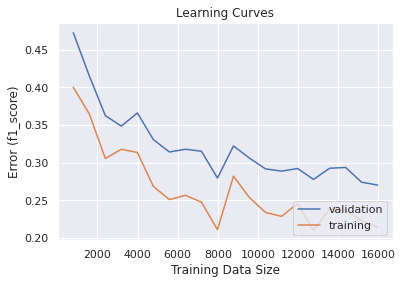

C = 0.5, penalty = elasticnet,  l1_ratio = 0.3, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.81070   0.76808   0.78881      1065
     antivax    0.77344   0.33446   0.46698       296
      provax    0.66376   0.82519   0.73572       921

    accuracy                        0.73488      2282
   macro avg    0.74930   0.64257   0.66384      2282
weighted avg    0.74656   0.73488   0.72564      2282



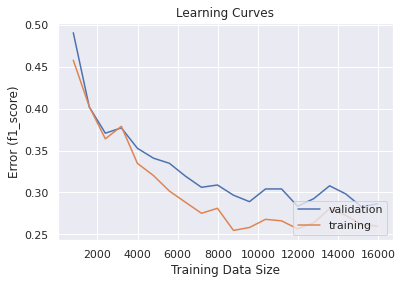

C = 0.5, penalty = elasticnet,  l1_ratio = 0.5, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78411   0.78779   0.78595      1065
     antivax    0.65672   0.44595   0.53119       296
      provax    0.68249   0.74919   0.71429       921

    accuracy                        0.72787      2282
   macro avg    0.70777   0.66098   0.67714      2282
weighted avg    0.72657   0.72787   0.72398      2282



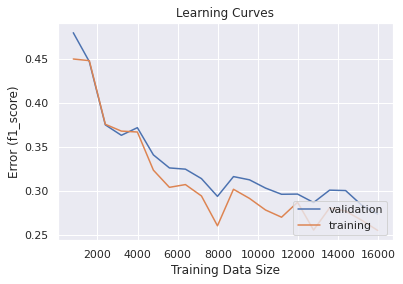

C = 0.5, penalty = elasticnet,  l1_ratio = 0.75, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78413   0.79812   0.79107      1065
     antivax    0.73333   0.33446   0.45940       296
      provax    0.67262   0.77633   0.72077       921

    accuracy                        0.72918      2282
   macro avg    0.73003   0.63630   0.65708      2282
weighted avg    0.73254   0.72918   0.71967      2282



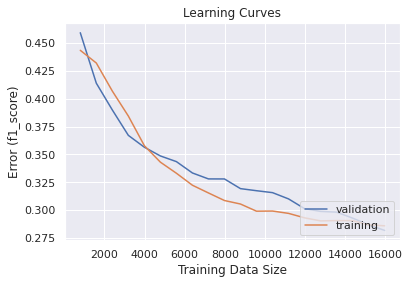

C = 0.75, penalty = elasticnet,  l1_ratio = 0.15, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.79210   0.79061   0.79135      1065
     antivax    0.73620   0.40541   0.52288       296
      provax    0.68845   0.78936   0.73546       921

    accuracy                        0.74014      2282
   macro avg    0.73891   0.66179   0.68323      2282
weighted avg    0.74301   0.74014   0.73397      2282



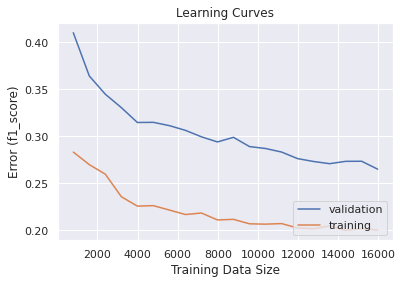

C = 0.75, penalty = elasticnet,  l1_ratio = 0.3, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.79563   0.78592   0.79074      1065
     antivax    0.74843   0.40203   0.52308       296
      provax    0.68627   0.79805   0.73795       921

    accuracy                        0.74102      2282
   macro avg    0.74344   0.66200   0.68392      2282
weighted avg    0.74537   0.74102   0.73472      2282



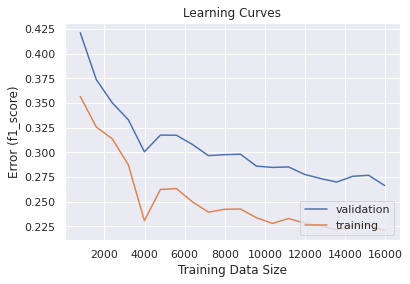

C = 0.75, penalty = elasticnet,  l1_ratio = 0.5, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78087   0.78967   0.78525      1065
     antivax    0.64474   0.49662   0.56107       296
      provax    0.70215   0.74484   0.72287       921

    accuracy                        0.73357      2282
   macro avg    0.70925   0.67705   0.68973      2282
weighted avg    0.73144   0.73357   0.73099      2282



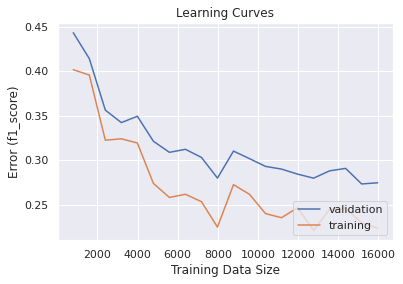

C = 0.75, penalty = elasticnet,  l1_ratio = 0.75, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78125   0.79812   0.78960      1065
     antivax    0.72611   0.38514   0.50331       296
      provax    0.68949   0.77633   0.73034       921

    accuracy                        0.73576      2282
   macro avg    0.73228   0.65320   0.67441      2282
weighted avg    0.73706   0.73576   0.72855      2282



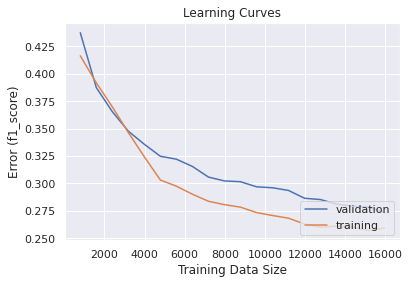

C = 1, penalty = elasticnet,  l1_ratio = 0.15, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.79151   0.78779   0.78965      1065
     antivax    0.72283   0.44932   0.55417       296
      provax    0.69461   0.78284   0.73609       921

    accuracy                        0.74189      2282
   macro avg    0.73631   0.67332   0.69330      2282
weighted avg    0.74349   0.74189   0.73749      2282



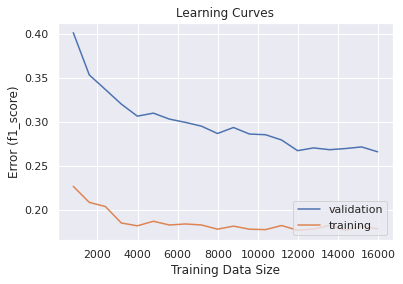

C = 1, penalty = elasticnet,  l1_ratio = 0.3, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.79202   0.78310   0.78754      1065
     antivax    0.70157   0.45270   0.55031       296
      provax    0.69268   0.78067   0.73405       921

    accuracy                        0.73926      2282
   macro avg    0.72876   0.67216   0.69063      2282
weighted avg    0.74020   0.73926   0.73518      2282



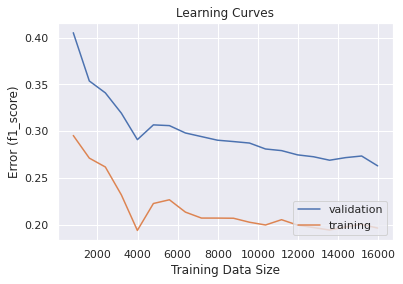

C = 1, penalty = elasticnet,  l1_ratio = 0.5, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.78301   0.79624   0.78957      1065
     antivax    0.64898   0.53716   0.58780       296
      provax    0.71488   0.74050   0.72747       921

    accuracy                        0.74014      2282
   macro avg    0.71562   0.69130   0.70161      2282
weighted avg    0.73813   0.74014   0.73833      2282



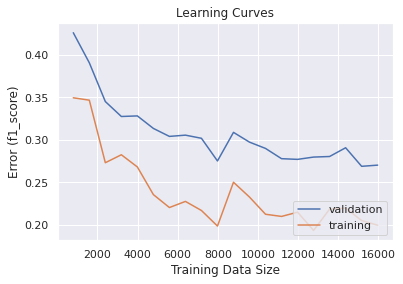

C = 1, penalty = elasticnet,  l1_ratio = 0.75, solver = saga, 
              precision    recall  f1-score   support

     neutral    0.77891   0.79061   0.78472      1065
     antivax    0.65517   0.51351   0.57576       296
      provax    0.70485   0.74159   0.72275       921

    accuracy                        0.73488      2282
   macro avg    0.71298   0.68190   0.69441      2282
weighted avg    0.73297   0.73488   0.73260      2282



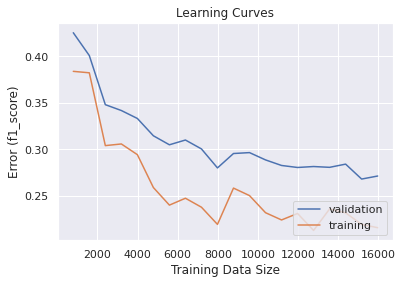

In [ ]:
param_sets = [
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l1'], 'solver': ['saga'], 'l1_ratio': [None]},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['l2'], 'solver': ['lbfgs'], 'l1_ratio': [None]},
  {'C': [0.1, 0.25 , 0.5, 0.75, 1], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.15, 0.3, 0.5, 0.75]},
]

for param_set in param_sets:
  for C in param_set['C']:
    for P in param_set['penalty']:
      for S in param_set['solver']:
        for R in param_set['l1_ratio']:
          print("C = %s, penalty = %s,  l1_ratio = %s, solver = %s, " % (C,P,R,S) )
          softmax = modelTraining(LogisticRegression(multi_class = 'multinomial', C = C, penalty = P, solver = S, l1_ratio = R), tfidf_training_set, tfidf_validation_set, f1_score, 'weighted')
          modelEvaluation(softmax, tfidf_validation_set, ['neutral', 'antivax', 'provax'])
          learningCurves(softmax, tfidf_training_set, tfidf_validation_set, f1_score, average = 'weighted')


# **Comparison with Multinomial Naive Bayes (another model for multiclass classification**)

                       Validation Set


              precision    recall  f1-score   support

     neutral    0.80289   0.73052   0.76500      1065
     antivax    0.67956   0.41554   0.51572       296
      provax    0.65194   0.80130   0.71895       921

    accuracy                        0.71823      2282
   macro avg    0.71146   0.64912   0.66656      2282
weighted avg    0.72597   0.71823   0.71408      2282



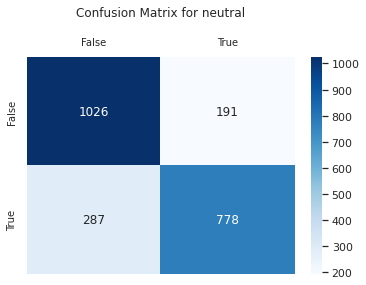

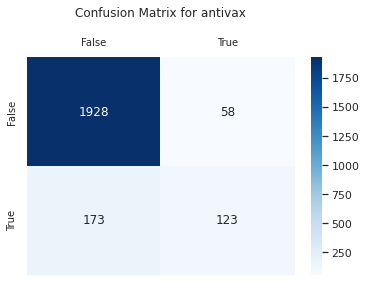

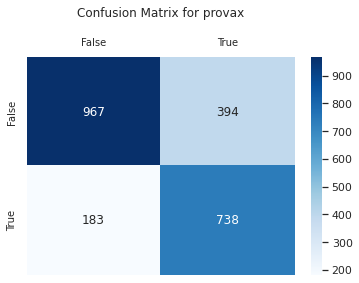

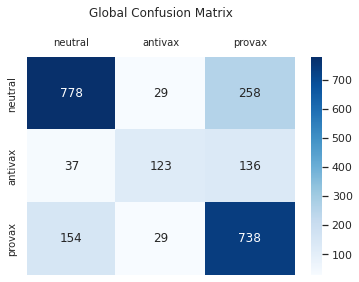

                       Training Set


              precision    recall  f1-score   support

     neutral    0.89192   0.83655   0.86335      7458
     antivax    0.85530   0.60733   0.71030      2073
      provax    0.77174   0.89915   0.83059      6445

    accuracy                        0.83206     15976
   macro avg    0.83965   0.78101   0.80141     15976
weighted avg    0.83869   0.83206   0.83027     15976



In [ ]:
from sklearn.naive_bayes import MultinomialNB

multi_nb = modelTraining(MultinomialNB(alpha = 0.25), tfidf_training_set, tfidf_validation_set)
print('                       Validation Set\n\n')
modelEvaluation(multi_nb, tfidf_validation_set, ['neutral', 'antivax', 'provax'], cm_plot = True)
print('                       Training Set\n\n')
modelEvaluation(multi_nb, tfidf_training_set, ['neutral', 'antivax','provax'])